In [30]:
import sys
!pip install pandas
import pandas as pd
import numpy as np
import nltk


import re
import nltk
from joblib import dump, load
import matplotlib.pyplot as plt
pd.options.display.max_colwidth=200
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  # Asegúrate de importar StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score




import scipy.stats as stats
import seaborn as sns; sns.set()  # for plot styling

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree


from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold

# Metricas
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# q-q plots
import scipy.stats as stats

In [31]:
!pip install LightFM
from lightfm import LightFM
from lightfm.data import Dataset

## Carga de datos

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
pd2 = pd.read_csv('/content/drive/MyDrive/Corona/b2b_nuevo.csv' , sep=",", encoding="utf-8")

In [34]:

b2b = pd2.copy()

## Implementación B2B

In [35]:
print(b2b.columns.tolist())

['fecha_factura', 'id_b2b', 'municipio', 'zona', 'categoria_b2b_macro', 'categoria_b2b', 'subcategoria_b2b', 'producto', 'valor_total', 'alineación con portafolio estratégico b2b', 'Total de unidades', 'Total de edificaciones en obra']


In [36]:
categorical_cols = b2b.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['fecha_factura', 'id_b2b', 'municipio', 'zona', 'categoria_b2b_macro',
       'categoria_b2b', 'subcategoria_b2b', 'producto'],
      dtype='object')


### Manejo Categóricas

Fue necesario darle un manejo distinto a las variables categóricas, ya que al tener tantas categorías perjudican e imposibilitan la elaboración del modelo de recomendación

In [37]:
cat_cols = ['id_b2b', 'municipio', 'zona', 'categoria_b2b_macro',
       'categoria_b2b', 'subcategoria_b2b', 'producto']

Se utiliza la técnica de Label Encoder

In [38]:
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    b2b[f'{col}_enc'] = le.fit_transform(b2b[col].astype(str))
    label_encoders[col] = le


## Pipeline LightFM

In [39]:
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
import numpy as np

b2b[cat_cols] = b2b[cat_cols].astype(str)

# Inicialización
dataset = Dataset()
dataset.fit(
    users=b2b['id_b2b'].unique(),
    items=b2b['producto'].unique()
)


dataset.fit_partial(
    users=b2b['id_b2b'],
    items=b2b['producto'],
    user_features=np.unique([
        *("municipio:" + b2b['municipio']),
        *("zona:" + b2b['zona']),
        *("unidades:" + b2b['Total de unidades'].astype(str)),
        *("edificaciones:" + b2b['Total de edificaciones en obra'].astype(str))
    ]),
    item_features=np.unique([
        *("cat_macro:" + b2b['categoria_b2b_macro']),
        *("cat:" + b2b['categoria_b2b']),
        *("subcat:" + b2b['subcategoria_b2b'])
    ])
)


# Interacciones
(interactions, _) = dataset.build_interactions(
    ((row['id_b2b'], row['producto'], row['valor_total']) for _, row in b2b.iterrows())
)

# User features
user_features = dataset.build_user_features(
    ((row['id_b2b'], [
        f"municipio:{row['municipio']}",
        f"zona:{row['zona']}",
        f"unidades:{row['Total de unidades']}",
        f"edificaciones:{row['Total de edificaciones en obra']}"
    ]) for _, row in b2b.iterrows())
)

# Item features
item_features = dataset.build_item_features(
    ((row['producto'], [
        f"cat_macro:{row['categoria_b2b_macro']}",
        f"cat:{row['categoria_b2b']}",
        f"subcat:{row['subcategoria_b2b']}"
    ]) for _, row in b2b.iterrows())
)

# Entrenamiento
model_lfm = LightFM(loss='warp')
model_lfm.fit(interactions,
          user_features=user_features,
          item_features=item_features,
          epochs=10,
          num_threads=4)

# Evaluación
precision = precision_at_k(model_lfm, interactions, user_features=user_features,
                           item_features=item_features, k=5).mean()
recall = recall_at_k(model_lfm, interactions, user_features=user_features,
                     item_features=item_features, k=5).mean()
auc = auc_score(model_lfm, interactions, user_features=user_features,
                item_features=item_features).mean()

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")


Precision: 1.0000
Recall: 0.0048
AUC: 0.8659


In [40]:

user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()


usuario = list(user_id_map.keys())[2]
usuario_idx = user_id_map[usuario]


n_items = len(item_id_map)


scores = model_lfm.predict(
    usuario_idx,
    np.arange(n_items),
    user_features=user_features,
    item_features=item_features
)


top_items_idx = np.argsort(-scores)


reverse_item_map = {v: k for k, v in item_id_map.items()}
top_productos = [reverse_item_map[i] for i in top_items_idx[:10]]

print(f"Recomendaciones para usuario {usuario}:\n", top_productos)


Recomendaciones para usuario B2B_03:
 ['Producto_1139', 'Producto_1053', 'Producto_552', 'Producto_1054', 'Producto_553', 'Producto_1411', 'Producto_1361', 'Producto_831', 'Producto_1388', 'Producto_1362']


## Modelo Tabular

In [41]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import pandas as pd
import itertools

# --- Preprocesamiento ---
b2b[cat_cols] = b2b[cat_cols].astype(str)
b2b['comprado'] = 1

# --- Construcción de universo completo cliente-producto ---
clientes = b2b['id_b2b'].unique()
productos = b2b['producto'].unique()

combinaciones = pd.DataFrame(list(itertools.product(clientes, productos)), columns=['id_b2b', 'producto'])

# Marcar los comprados reales
comprados = b2b[['id_b2b', 'producto']].drop_duplicates()
comprados['comprado'] = 1

# Merge para crear dataset con comprados y no comprados
df_all = combinaciones.merge(comprados, on=['id_b2b', 'producto'], how='left')
df_all['comprado'] = df_all['comprado'].fillna(0)

# Filtrar: muestreamos mismos positivos y mismos negativos para balancear
positivos_df = df_all[df_all['comprado'] == 1]
negativos_df = df_all[df_all['comprado'] == 0].sample(n=len(positivos_df), random_state=42)
df_final = pd.concat([positivos_df, negativos_df], ignore_index=True)

# --- Enriquecer con info de cliente y producto ---
cliente_info = b2b.drop_duplicates('id_b2b').set_index('id_b2b')[[
    'municipio', 'zona', 'valor_total', 'Total de unidades', 'Total de edificaciones en obra'
]]
producto_info = b2b.drop_duplicates('producto').set_index('producto')[[
    'categoria_b2b_macro', 'categoria_b2b', 'subcategoria_b2b'
]]

df_final = df_final.join(cliente_info, on='id_b2b')
df_final = df_final.join(producto_info, on='producto')

# --- Codificación ---
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_final[col] = le.fit_transform(df_final[col])
    encoders[col] = le

# --- Split en entrenamiento y holdout balanceado ---
positivos_df = df_final[df_final['comprado'] == 1]
negativos_df = df_final[df_final['comprado'] == 0]

train_pos, test_pos = train_test_split(positivos_df, test_size=0.2, random_state=42)
train_neg, test_neg = train_test_split(negativos_df, test_size=0.2, random_state=42)

train_df = pd.concat([train_pos, train_neg]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([test_pos, test_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

X_train = train_df.drop(columns=['comprado'])
y_train = train_df['comprado']
X_test = test_df.drop(columns=['comprado'])
y_test = test_df['comprado']

# --- Modelo con regularización ---
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=4,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=5,
    reg_lambda=10,
    random_state=42
)

# --- Validación cruzada ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

print(f"\nAUC promedio (5-fold CV): {scores.mean():.4f}")
print(f"AUC por fold: {np.round(scores, 4)}")

# --- Evaluación final con holdout ---
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nReporte de Clasificación (holdout):\n", classification_report(y_test, y_pred))
print("AUC (holdout):", roc_auc_score(y_test, y_prob))



AUC promedio (5-fold CV): 0.8735
AUC por fold: [0.873  0.8827 0.876  0.8691 0.8666]

Reporte de Clasificación (holdout):
               precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       977
         1.0       0.80      0.76      0.78       977

    accuracy                           0.79      1954
   macro avg       0.79      0.79      0.79      1954
weighted avg       0.79      0.79      0.79      1954

AUC (holdout): 0.8733181495795309


In [42]:
def recomendar_productos(id_b2b, modelo, df_original, df_codificado, encoders, top_n=5):
    # Filtrar productos ya comprados por el cliente
    productos_comprados = df_original[df_original['id_b2b'] == id_b2b]['producto'].unique()
    todos_los_productos = df_original['producto'].unique()
    productos_no_comprados = [p for p in todos_los_productos if p not in productos_comprados]

    if not productos_no_comprados:
        return f"Cliente {id_b2b} ya ha comprado todos los productos."

    # Tomar una muestra representativa del cliente
    cliente_info = df_original[df_original['id_b2b'] == id_b2b].iloc[0]

    # Generar filas nuevas combinando cliente con cada producto no comprado
    nuevas_filas = []
    for producto in productos_no_comprados:
        fila = cliente_info.copy()
        fila['producto'] = producto
        nuevas_filas.append(fila)

    pred_df = pd.DataFrame(nuevas_filas)

    # Eliminar columnas de producto si ya existen antes del join
    columnas_producto = ['categoria_b2b_macro', 'categoria_b2b', 'subcategoria_b2b']
    pred_df = pred_df.drop(columns=[col for col in columnas_producto if col in pred_df.columns], errors='ignore')

    # Agregar info del producto
    producto_info = df_original.drop_duplicates('producto').set_index('producto')[columnas_producto]
    pred_df = pred_df.set_index('producto').join(producto_info, on='producto').reset_index()

    # Codificar
    for col in encoders:
        if col in pred_df.columns:
            pred_df[col] = encoders[col].transform(pred_df[col])

    # Predecir
    X_pred = pred_df[modelo.get_booster().feature_names]
    proba = modelo.predict_proba(X_pred)[:, 1]
    pred_df['probabilidad'] = proba

    # Decodificar producto
    producto_le = encoders['producto']
    pred_df['producto_nombre'] = producto_le.inverse_transform(pred_df['producto'])

    return pred_df[['producto_nombre', 'probabilidad']].sort_values(by='probabilidad', ascending=False).head(top_n)


In [43]:
print(b2b['id_b2b'].unique())


['B2B_01' 'B2B_02' 'B2B_03' 'B2B_04' 'B2B_05' 'B2B_06']


In [44]:
recomendar_productos('B2B_01', model, b2b, df_final, encoders, top_n=10)


,producto_nombre,probabilidad
66,Producto_317,0.797145
65,Producto_316,0.792060
61,Producto_310,0.765170
1016,Producto_1566,0.761069
975,Producto_1498,0.759338
984,Producto_1509,0.759338
1006,Producto_1542,0.754916
68,Producto_323,0.750831
1103,Producto_1694,0.748766
1100,Producto_1686,0.746566


## Recomendador HIBRIDO

In [45]:
def recomendar_hibrido_b2b(cliente_id, top_n=10, alpha=0.5):
    # Validar existencia del cliente
    if cliente_id not in dataset.mapping()[0]:
        return f"Cliente {cliente_id} no está en el dataset de LightFM."

    # Productos ya comprados
    productos_comprados = set(b2b[b2b['id_b2b'] == cliente_id]['producto'].unique())
    productos_totales = b2b['producto'].unique()
    productos_candidatos = list(set(productos_totales) - productos_comprados)

    if not productos_candidatos:
        return f"Cliente {cliente_id} ya ha comprado todos los productos."

    # --- LightFM ---
    usuario_interno = dataset.mapping()[0][cliente_id]
    productos_idx = [dataset.mapping()[2][p] for p in productos_candidatos if p in dataset.mapping()[2]]
    scores_lfm = model_lfm.predict(
        user_ids=np.repeat(usuario_interno, len(productos_idx)),
        item_ids=productos_idx,
        user_features=user_features,
        item_features=item_features
    )

    df_lfm = pd.DataFrame({
        'producto': [p for p in productos_candidatos if p in dataset.mapping()[2]],
        'score_lfm': scores_lfm
    })

    # --- XGBoost ---
    cliente_info = b2b[b2b['id_b2b'] == cliente_id].iloc[0]
    nuevas_filas = []

    for producto in df_lfm['producto']:
        fila = cliente_info.copy()
        fila['producto'] = producto
        nuevas_filas.append(fila)

    pred_df = pd.DataFrame(nuevas_filas)

    # Codificar con los mismos encoders usados en XGBoost
    for col in encoders:
        pred_df[col] = encoders[col].transform(pred_df[col])

    X_pred = pred_df[model.get_booster().feature_names]
    scores_xgb = model.predict_proba(X_pred)[:, 1]

    # Unir scores
    df_lfm['score_xgb'] = scores_xgb
    df_lfm['score_hibrido'] = alpha * df_lfm['score_lfm'] + (1 - alpha) * df_lfm['score_xgb']

    return df_lfm.sort_values('score_hibrido', ascending=False).head(top_n)[['producto', 'score_lfm', 'score_xgb', 'score_hibrido']]


In [46]:
recomendar_hibrido_b2b(cliente_id="B2B_01", top_n=10, alpha=0.6)


,producto,score_lfm,score_xgb,score_hibrido
1482,Producto_1893,-7.389040,0.329593,-4.301587
1210,Producto_881,-7.469498,0.256675,-4.379029
340,Producto_884,-7.815102,0.256675,-4.586391
1242,Producto_394,-8.300550,0.735644,-4.686072
1690,Producto_424,-8.300843,0.696297,-4.701987
1002,Producto_1686,-8.350239,0.519311,-4.802419
1251,Producto_275,-8.501793,0.733272,-4.807767
1903,Producto_914,-8.239782,0.258371,-4.840521
1875,Producto_385,-8.664514,0.742663,-4.901643
375,Producto_286,-8.678282,0.741152,-4.910509


## Comparación de Modelos

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

def comparar_modelos_b2b(cliente_id, top_n=30, alpha=0.5, normalizar_lfm=True):
    df_scores = recomendar_hibrido_b2b(cliente_id=cliente_id, top_n=top_n, alpha=alpha)

    if isinstance(df_scores, str):
        print(df_scores)
        return

    # --- Normalizar LightFM si se requiere ---
    if normalizar_lfm:
        min_lfm, max_lfm = df_scores['score_lfm'].min(), df_scores['score_lfm'].max()
        df_scores['score_lfm_norm'] = (df_scores['score_lfm'] - min_lfm) / (max_lfm - min_lfm)
        df_scores['score_hibrido_norm'] = alpha * df_scores['score_lfm_norm'] + (1 - alpha) * df_scores['score_xgb']
        cols_plot = ['score_lfm_norm', 'score_xgb', 'score_hibrido_norm']
    else:
        cols_plot = ['score_lfm', 'score_xgb', 'score_hibrido']

    # --- Estadísticas descriptivas ---
    print("Estadísticas de scores:\n")
    for col in cols_plot:
        print(f"{col}:\n{df_scores[col].describe()}\n")

    # --- Gráfico comparativo ---
    df_plot = df_scores.melt(id_vars='producto', value_vars=cols_plot,
                             var_name='modelo', value_name='score')

    plt.figure(figsize=(14, 6))
    sns.barplot(data=df_plot, x='producto', y='score', hue='modelo', palette='Set2')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Comparación de scores para Cliente {cliente_id}")
    plt.ylabel("Score")
    plt.xlabel("Producto")
    plt.legend(title='Modelo')
    plt.tight_layout()
    plt.show()

    # --- Comparación de rankings ---
    df_scores['rank_lfm'] = df_scores['score_lfm'].rank(ascending=False)
    df_scores['rank_xgb'] = df_scores['score_xgb'].rank(ascending=False)
    df_scores['rank_diff'] = df_scores['rank_xgb'] - df_scores['rank_lfm']

    print("\nTop 5 mayores diferencias de ranking (XGBoost vs LightFM):")
    print(df_scores[['producto', 'rank_lfm', 'rank_xgb', 'rank_diff']].sort_values('rank_diff', key=abs, ascending=False).head())


Estadísticas de scores:

score_lfm_norm:
count    15.000000
mean      0.327063
std       0.313995
min       0.000000
25%       0.097838
50%       0.203496
75%       0.369294
max       1.000000
Name: score_lfm_norm, dtype: float64

score_xgb:
count    15.000000
mean      0.512242
std       0.197858
min       0.252320
25%       0.293982
50%       0.522294
75%       0.714784
max       0.742663
Name: score_xgb, dtype: float64

score_hibrido_norm:
count    15.000000
mean      0.401135
std       0.155000
min       0.204272
25%       0.280355
50%       0.349278
75%       0.494852
max       0.731837
Name: score_hibrido_norm, dtype: float64



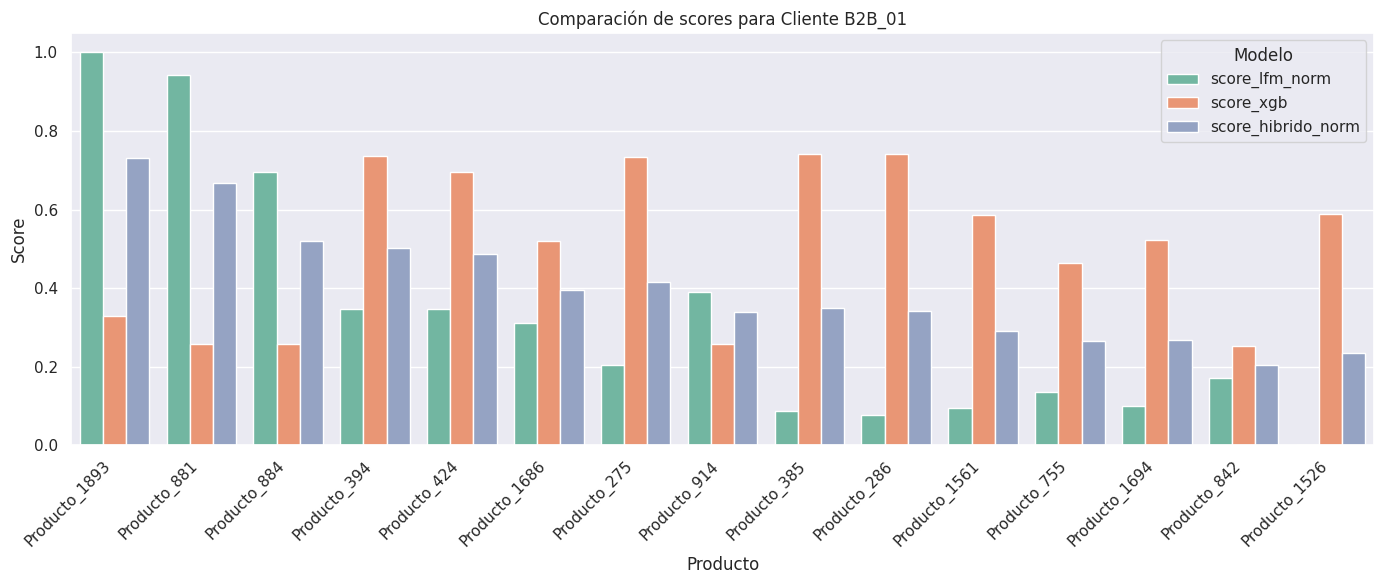


Top 5 mayores diferencias de ranking (XGBoost vs LightFM):
           producto  rank_lfm  rank_xgb  rank_diff
1875   Producto_385      13.0       1.0      -12.0
375    Producto_286      14.0       2.0      -12.0
1210   Producto_881       2.0      13.5       11.5
340    Producto_884       3.0      13.5       10.5
1482  Producto_1893       1.0      11.0       10.0


In [48]:
comparar_modelos_b2b(cliente_id="B2B_01", top_n=15, alpha=0.6)

